# Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Data & Preprocess

In [2]:
lock_meas  = '..\\..\\DATA\\RAW\\Measure_04' # Location folder of the measurement files
meas_date  = '2018_ 11_ 27_9_45_58_'                 # Longest run, complex data set
stand_date = '2018_ 11_ 27_9_39_00_'                 # Use this file to calibrate ACCELERO
roll_date  = '2018_ 11_ 27_9_39_13_'                 # Use this file to calibraet MAGNETO


# >>> This part is visualised in: Visu_RawData notebook <<<

# Load the Accelero calibration file.
acc_calib = pd.read_csv(lock_meas + '\\StandStill\\' + stand_date + 'IMU.txt',
                               sep='\t',
                               decimal=',',
                               names=['time', 'acc0', 'acc1', 'acc2', 'gyro0', 'gyro1', 'gyro2', 'mag0', 'mag1', 'mag2'])

# Delete invalid data and convert into array
acc_calib = acc_calib[~(acc_calib[['acc0','acc1','acc2']] == 0).any(axis=1)]
acc_ar = np.array(acc_calib)

# Load the Magneto calibration file. 
mag_calib = pd.read_csv(lock_meas + '\\RollStill\\' + roll_date + 'IMU.txt',
                               sep='\t',
                               decimal=',',
                               names=['time', 'acc0', 'acc1', 'acc2', 'gyro0', 'gyro1', 'gyro2', 'mag0', 'mag1', 'mag2'])

# Delete invalid data and convert into array
mag_calib = mag_calib[~(mag_calib[['mag0','mag1','mag2']] == 0).any(axis=1)]
mag_ar = np.array(mag_calib)

# Load the IMU csv data file
imu_data = pd.read_csv(lock_meas + '\\LongRun\\' + meas_date + 'IMU.txt',
                               sep='\t',
                               decimal=',',
                               names=['time', 'acc0', 'acc1', 'acc2', 'gyro0', 'gyro1', 'gyro2', 'mag0', 'mag1', 'mag2'])

# Load the MoCap csv data file
mocap_data = pd.read_csv(lock_meas + '\\LongRun\\' + meas_date + 'MoCap.txt',
                                 sep='\t',
                                 decimal=',',
                                 names=['time', 'x', 'y', 'z', 'tracked', 'beta', 'Qx', 'Qy', 'Qz', 'Qw'])

# Merge the two data file to synronise them. In both dataset there are some data row that can't be matched, this data will
# be trown away
data = pd.merge(imu_data, mocap_data, on=['time'], how='inner')

# ===== Filters ======

# When the magneto sensors values are [0, 0, 0] that is a false value. These rows are deleted.
# When tacked is 0, it is indicates that the MoCap data is invalid. These rows are deleted too.
df = data[~(data[['acc0','acc1','acc2','mag0','mag1','mag2','tracked']] == 0).any(axis=1)]
# From now on the tracked column can be deleted, because it contains only 1s.
del df['tracked']

# Add to more columns to make a delta time (delta_t) and delta posotions (delta_x, delta_y, delta_z) 
df = df.assign(delta_t=0)
df = df.assign(delta_x=0)
df = df.assign(delta_y=0)
df = df.assign(delta_z=0)

# Save the header
header = df.columns

# Convert the data frame into numpy array
dfarray = np.array(df)

# Create a lookup table to make the use of this matrix more readable.
time    = 0
acc0    = 1
acc1    = 2
acc2    = 3
gyro0   = 4
gyro1   = 5
gyro2   = 6
mag0    = 7
mag1    = 8
mag2    = 9
x       = 10
y       = 11
z       = 12
beta    = 13
Qx      = 14
Qy      = 15
Qz      = 16
Qw      = 17
delta_t = 18
delta_x = 19
delta_y = 20
delta_z = 21

# Calculate the deltas (time, x, y, z) between two valid measurements
for i in range(dfarray.shape[0]):
    if (i-1)>-1:
        dfarray[i,delta_t] = dfarray[i,time]-dfarray[i-1,time]
        dfarray[i,delta_x] = dfarray[i,x]-dfarray[i-1,x]
        dfarray[i,delta_y] = dfarray[i,y]-dfarray[i-1,y]
        dfarray[i,delta_z] = dfarray[i,z]-dfarray[i-1,z]

# Filter the peeks in deltas (lost wifi connection stops the robot -> indicates peek in time meenwhile no movement in the robot)        
window = 5
sliding_avg = 0
for i in range(dfarray.shape[0]):
    if i>window:
        temp_t = (dfarray[i-4,delta_t]+dfarray[i-3,delta_t]+dfarray[i-2,delta_t]+dfarray[i-1,delta_t])/4        
        if dfarray[i,delta_t] > temp_t*20: # 20 -> experimental constant
            dfarray[i,delta_t]= temp_t     # sliding_avg

for i in range(dfarray.shape[0]):
    if i>2:
        if (abs(dfarray[i,delta_x]) > 0.05): 
            dfarray[i,delta_x] = 0
        if (abs(dfarray[i,delta_y]) > 0.05): 
            dfarray[i,delta_y] = 0
        if (abs(dfarray[i,delta_z]) > 0.05): 
            dfarray[i,delta_z] = 0
            
for i in range(dfarray.shape[0]):            
    dfarray[i,delta_t] = dfarray[i,delta_t]*9   # as a normalization multiply the time by 9 as 9ms is the synronisation time
    dfarray[i,delta_x] = dfarray[i,delta_x]*100 # scaling m to mm
    dfarray[i,delta_y] = dfarray[i,delta_y]*100 # scaling m to mm
    dfarray[i,delta_z] = dfarray[i,delta_z]*100 # scaling m to mm

#=== Start Accelero Calibration ===
# >>>This part is visualised in Visu_CalibrateAccelero notebook.<<<
acc0_mean = np.mean(acc_ar[:,acc0])
acc1_mean = np.mean(acc_ar[:,acc1])
acc2_mean = np.mean(acc_ar[:,acc2])

for i in range(dfarray.shape[0]):
    dfarray[i, acc0] = dfarray[i, acc0] - acc0_mean
    dfarray[i, acc1] = dfarray[i, acc1] - acc1_mean
    dfarray[i, acc2] = dfarray[i, acc2] - acc2_mean
#=== End Accelero Calibration ===
             
#==== Start Megneto Calibration ===
# >>>This part is visualised in Visu_CalibrateMagneto notebook.<<<
# Megneto Calibration Applied
# Hard iron distorsion compensation (constant offset elimination)
mag0_off = (mag_ar[:,mag0].max()+mag_ar[:,mag0].min())/2
mag1_off = (mag_ar[:,mag1].max()+mag_ar[:,mag1].min())/2
mag2_off = (mag_ar[:,mag2].max()+mag_ar[:,mag2].min())/2

# Soft iron distorsion compensation
mag0_d = (mag_ar[:,mag0].max() - mag_ar[:,mag0].min())/2
mag1_d = (mag_ar[:,mag1].max() - mag_ar[:,mag1].min())/2
mag2_d = (mag_ar[:,mag2].max() - mag_ar[:,mag2].min())/2

for i in range(dfarray.shape[0]):
    dfarray[i, mag0] = (dfarray[i, mag0] - mag0_off) / mag0_d
    dfarray[i, mag1] = (dfarray[i, mag1] - mag1_off) / mag1_d
    dfarray[i, mag2] = (dfarray[i, mag2] - mag2_off) / mag2_d
#=== End Magneto Calibration ===

#=== Gyroscope normalization ===
# >>>This part is visualised in Visu_CalibrateGyro notebook.<<<
# We need to normalize the gyroscope data, but we can use only some guessed value
scale0 = 35.399
scale1 = 25.872
scale2 = 83.7175

for i in range(dfarray.shape[0]):
    dfarray[i, gyro0] = dfarray[i, gyro0] / scale0
    dfarray[i, gyro1] = dfarray[i, gyro1] / scale1
    dfarray[i, gyro2] = dfarray[i, gyro2] / scale2
#=== End Gyroscope normaliization ==

#=== Orientation normalization ===
for i in range(dfarray.shape[0]):
    dfarray[i, beta] = dfarray[i, beta] / 180
#=== End Orientation normalization ===

df = pd.DataFrame(np.around(dfarray, 4), columns=header)

#=== Delete unnecessary columns ===#
del df['time']

cols = df.columns.tolist()
cols = cols[17:18] + cols[:17] + cols[18:]
df = df[cols]

In [3]:
df.to_csv('PreprocessedData_v3.txt', sep='\t', encoding='utf-8', index=False)

In [4]:
df.head(1)

,delta_t,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,...,y,z,beta,Qx,Qy,Qz,Qw,delta_x,delta_y,delta_z
0,0.0,-0.0029,0.0003,-0.0003,-0.0194,0.0124,-0.0022,-0.5292,-0.6538,-0.5275,...,0.221,0.402,-0.0129,0.005,0.02,0.0,1.0,0.0,0.0,0.0


# Data Check after Preprocess

In [5]:
df = pd.read_csv('PreprocessedData_v3.txt',
                               sep='\t',
                               decimal=',')
header = df.columns
df_arr =np.array(df, dtype='float64')
df =pd.DataFrame(df_arr, columns=header)

In [6]:
df.head(5)

,delta_t,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,...,y,z,beta,Qx,Qy,Qz,Qw,delta_x,delta_y,delta_z
0,0.0000,-0.0029,0.0003,-0.0003,-0.0194,0.0124,-0.0022,-0.5292,-0.6538,-0.5275,...,0.221,0.402,-0.0129,0.005,0.020,0.000,1.0,0.0,0.0,0.0
1,0.0891,-0.0029,0.0013,0.0007,-0.0085,0.0023,0.0006,-0.5292,-0.6538,-0.4945,...,0.221,0.402,-0.0128,0.005,0.020,0.001,1.0,0.0,0.0,0.0
2,0.0810,-0.0039,0.0013,-0.0003,-0.0199,0.0086,-0.0024,-0.5162,-0.6538,-0.5275,...,0.221,0.402,-0.0133,0.005,0.021,-0.000,1.0,0.0,0.0,0.0
3,0.3375,-0.0039,0.0013,0.0007,-0.0216,0.0054,-0.0002,-0.5162,-0.6538,-0.4945,...,0.221,0.402,-0.0129,0.005,0.020,0.000,1.0,0.0,0.0,0.0
4,0.0837,-0.0029,0.0023,0.0007,-0.0199,0.0171,0.0005,-0.5292,-0.6538,-0.4945,...,0.221,0.402,-0.0129,0.005,0.020,0.000,1.0,0.0,0.0,0.0


The saved file is looking good, as expected.

# Some plot to Check the data

In [7]:
df.shape

(7678, 21)

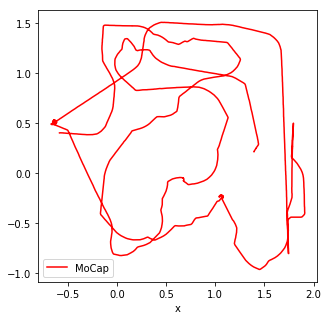

In [8]:
df.plot(x='x', y='z', color='red', figsize=(5,5), label='MoCap')
plt.show()

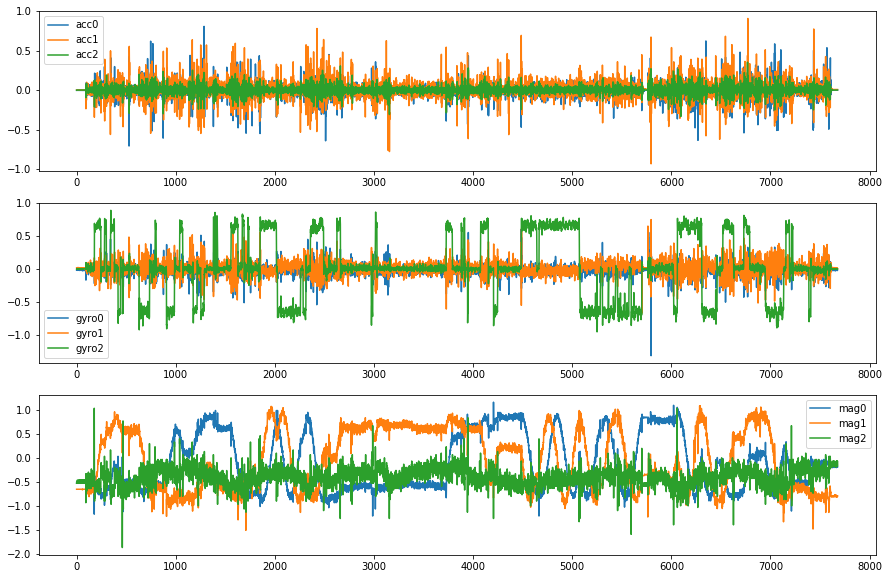

In [9]:
f1, (ax1, ax2, ax3) = plt.subplots(3, 1)
df.plot(y='acc0', figsize=(15,10), ax=ax1)
df.plot(y='acc1', ax=ax1)
df.plot(y='acc2', ax=ax1)
df.plot(y='gyro0', ax=ax2)
df.plot(y='gyro1', ax=ax2)
df.plot(y='gyro2', ax=ax2)
df.plot(y='mag0', ax=ax3)
df.plot(y='mag1', ax=ax3)
df.plot(y='mag2', ax=ax3)
plt.show()

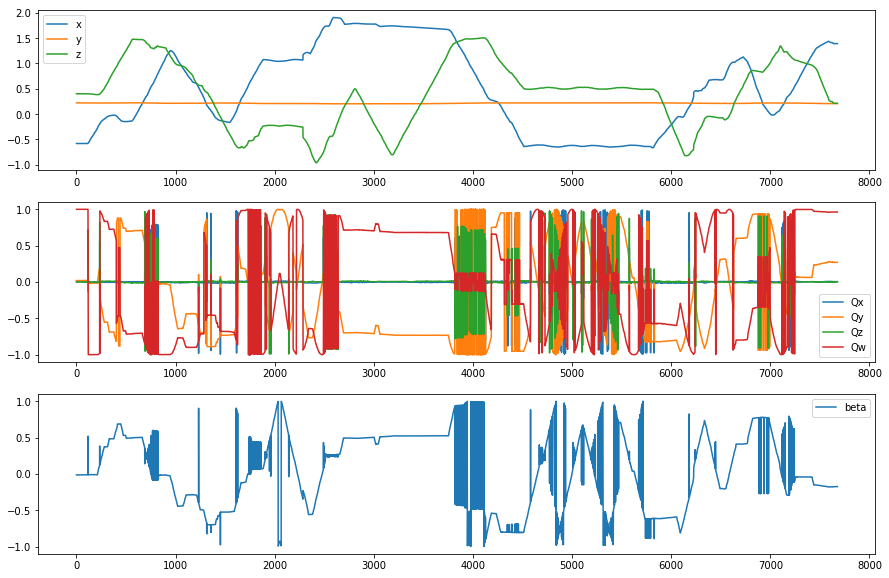

In [10]:
f2, (ax4, ax5, ax6) = plt.subplots(3, 1)
df.plot(y='x', figsize=(15,10), ax=ax4)
df.plot(y='y', ax=ax4)
df.plot(y='z', ax=ax4)
df.plot(y='Qx', ax=ax5)
df.plot(y='Qy', ax=ax5)
df.plot(y='Qz', ax=ax5)
df.plot(y='Qw', ax=ax5)
df.plot(y='beta', ax=ax6)
plt.show()

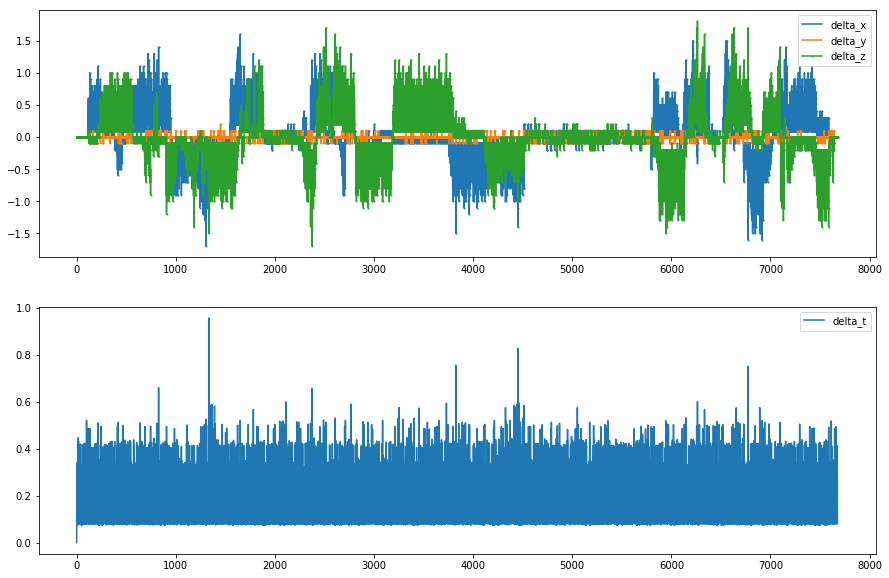

In [11]:
f3, (ax7, ax8) = plt.subplots(2, 1)
df.plot(y='delta_x', linestyle='-', marker='o', markersize=1, figsize=(15,10), ax=ax7)
df.plot(y='delta_y', linestyle='-', marker='o', markersize=1, ax=ax7)
df.plot(y='delta_z', linestyle='-', marker='o', markersize=1, ax=ax7)
df.plot(y='delta_t', ax=ax8)
plt.show()